<a href="https://colab.research.google.com/github/AmirMansurian/Epipolar-Geometry/blob/main/FundamentalMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
from sklearn.metrics import mean_squared_error
import scipy.io
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

Normalization function gets coordinates in hemogenous and normalize them that distance of each points to it's center is less than sqrt(2). it returns normalized points and normalizer matrix. for normalizer matrix N we have : normalized_point = N * point

In [80]:
def normalize(X) :
  
  center = X.mean(0)
  pts = np.zeros((8, 3))
  pts[:, 0] = X[:, 0] - center[0]
  pts[:, 1] = X[:, 1] - center[1]
  pts[:, 2] = 0
  
  mean_dist = np.sqrt(pow(pts, 2).sum(1)).mean()
  scale = np.sqrt(2)/mean_dist
  normal = np.array([[scale, 0, -scale*center[0]], [0, scale, -scale*center[1]], [0, 0, 1]])
  new_x = (np.matmul(X, normal.transpose()))

  return new_x, normal

FundamentalMatrix function gets correspondence points in hemogenous coordinates and returns estimation of fundamental matrix according to coorespondence points. we have equation X*F = 0 which X is kronecker of correspondence points. solution of this equation is eigenvector associated with smallest eigenvalue of X. so this function first normalizes points and calculate cronecker of points and stores in A matrix. after finding smallest eigenvector we have 3**3 matrix. as we know fundamental matrix has a constraint that it's smallest eigenvalue is 0. so we decompose result of previous section to U, Sigma and V matrixes and set smallest eigenvalue to 0 and then reconstruct the F. at last because of normalization step we should return F matrix to it's unnormalized version. so we have this : F_final = N2_transpose * F * N1, where N1 and N2 are normalizer matrix for correspondence points. and finally divide F matrix by it's (3,3) and returns F as estimation of fundamental matrix.

In [221]:
def FundamentalMatrix (X, Y) : 

  pts1, normal1 = normalize(X)  # normalize points of image 1
  pts2, normal2 = normalize(Y)  # normalize points of image 2

  A = np.append(x2*x1, x2*y1, axis=1)
  A = np.append(A, x2, axis=1)
  A = np.append(A, y2*x1, axis=1)
  A = np.append(A, y2*y1, axis=1)
  A = np.append(A, y2, axis=1)
  A = np.append(A, x1, axis=1)
  A = np.append(A, y1, axis=1)
  A = np.append(A, np.ones((8, 1)), axis=1)


  U, Sigma, V = np.linalg.svd(A)
  res = V[8, :].reshape(3,3)
  S = np.zeros((3,3))

  U, Sigma, V = np.linalg.svd(res)
  Vt = V.transpose()
  F = np.matmul(np.array([U[:, 0]]).transpose()*Sigma[0], np.array([Vt[:, 0]])) + np.matmul(np.array([U[:, 1]]).transpose()*Sigma[1], np.array([Vt[:, 1]])) 

  F = np.matmul(np.matmul(np.transpose(normal2),F), normal1)
  F = F/F[2,2]

  return F

Here I have tested Fundamental matrix of my own function with cv2 built-in function and you can see MSE parameter between results that shows we have  a very good estimation for F :

In [222]:
I4 = np.array([[83, 245, 1], [39, 461, 1], [284, 243, 1],[328, 459, 1],   # points of image1 in hemegenous coordinates
              [331, 166, 1], [286, 47, 1], [291, 332, 1],[296, 303, 1]])
I5 = np.array([[36, 155, 1], [34, 625, 1], [329, 158, 1],[323, 627, 1],   # points of image2 in hemegenous coordinates
              [375, 714, 1], [375, 67, 1], [313, 398, 1],[327, 331, 1]])

F = FundamentalMatrix(I4, I5) # calculate fundamental matrix implemented in previous section

p1 = np.array([[83, 245], [39, 461], [284, 243],[328, 459],   # points of image1 in 2D coordinates
              [331, 166], [286, 47], [291, 332],[296, 303]])
p2 = np.array([[36, 155], [34, 625], [329, 158],[323, 627],   # points of image2 in 2D coordinates
              [375, 714], [375, 67], [313, 398],[327, 331]])

f, mask = cv2.findFundamentalMat(p1, p2, method=cv2.FM_8POINT)  #calculate fundamental matrix with CV2 package built-in function

print('fundamental matrix calculated with implemented function:\n', F, '\n \n', 'fundamental matrix calculated with CV2 package:\n', f)
print(f'\n MSE of fundamental matrixes = {mean_squared_error(F,f) }')

fundamental matrix calculated with implemented function:
 [[ 1.90856596e-07  8.00509843e-06  4.16272697e-03]
 [ 2.31483703e-06  2.21119952e-07 -3.58237564e-04]
 [-9.36663106e-03 -1.75119128e-03  1.00000000e+00]] 
 
 fundamental matrix calculated with CV2 package:
 [[ 1.90856596e-07  8.00509843e-06  4.16272697e-03]
 [ 2.31483703e-06  2.21119952e-07 -3.58237564e-04]
 [-9.36663106e-03 -1.75119128e-03  1.00000000e+00]]

 MSE of fundamental matrixes = 1.0732639268100627e-29


function below gets two images of the same scene and their correspondence points and draws epipolar points and epipolar lines.

In [234]:
def drawlines(img1,img2,lines,pts1,pts2, select):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape[:2]
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        if select :
          img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 8)
        img1 = cv2.circle(img1,tuple(pt1),5,color, thickness = 30)
        img2 = cv2.circle(img2,tuple(pt2),5,color, thickness = 30)
    return img1,img2

Here we have two images of the same scene that have narrow baseline. also "points_inlier.mat" contains 20 good correspondence points between two images nad all of them are inlier. now we read images and show key points in each of images : 
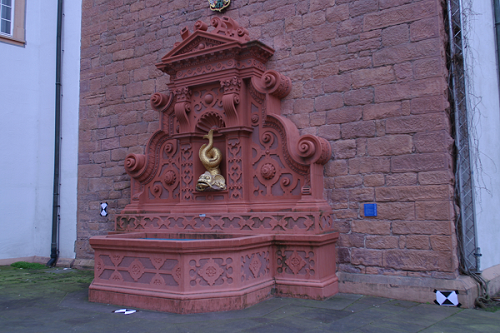       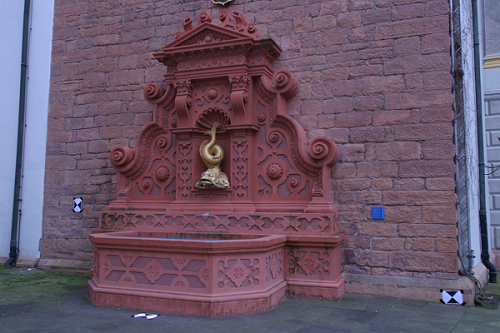

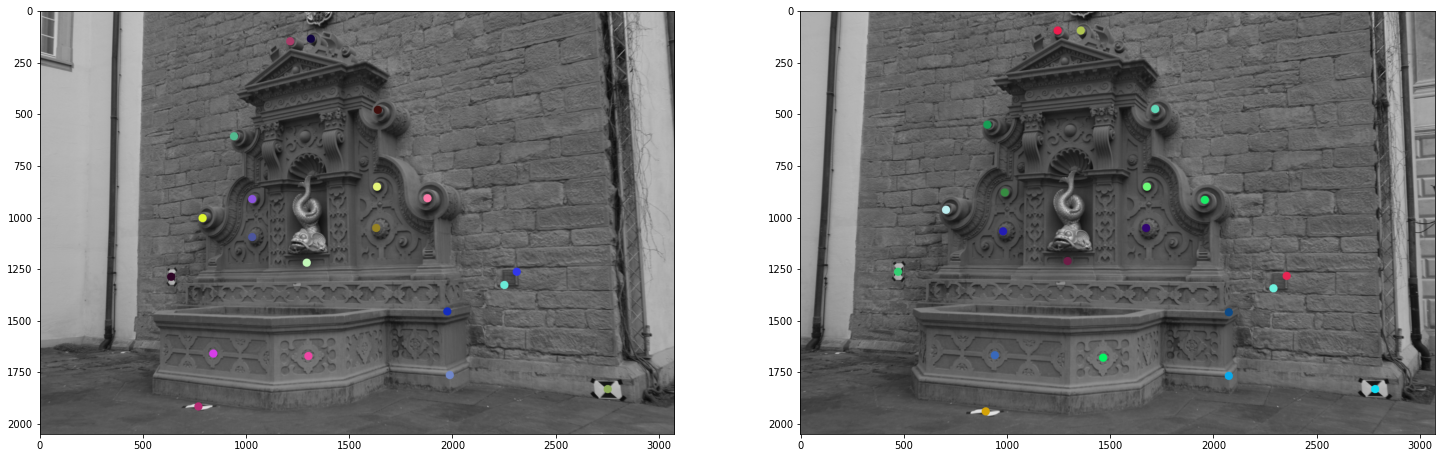

In [241]:
image1 = cv2.imread('img1.png', 0)
image2 = cv2.imread('img2.png', 0)
mat = scipy.io.loadmat('points_inliers.mat')
points1 = np.int32(mat['X1'])
points2 = np.int32(mat['X2'])

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(points2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(image1,image2,lines1,points1,points2, 0)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(points1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(image2,image1,lines2,points2,points1, 0)

figure(figsize=(25, 25))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

as we need just 8 points to calculate Fundamental matrixso I have choosed 8 good points between these 20 points. I have choosed good corner points and also rigs that are in the picture to have a good estimation of Fundamental matrix. below you can see points I have choosed: 
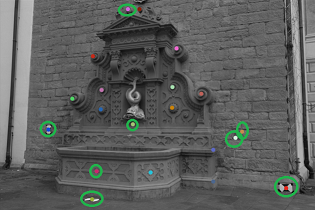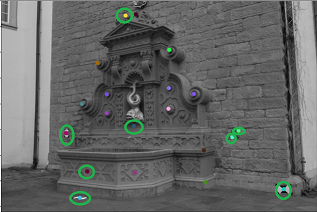

Now we use 8 highlited points and calculate Fundamental matrix with our own function and draw epipolar points and epipolar lines of the two images. as you can see epipolar lines are precise.

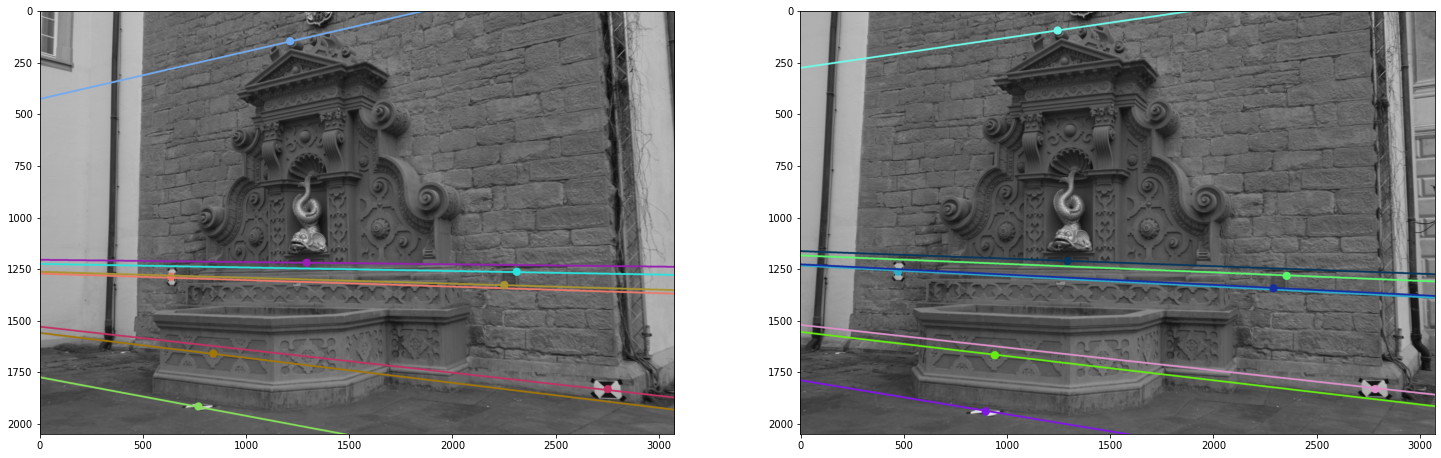

In [240]:
pts2 = np.array([[1246, 94, 1], [2782, 1830, 1], [898, 1938, 1],[474, 1262, 1],   # points of right image in hemegenous coordinates
              [1294, 1210, 1], [2354, 1282, 1], [2290, 1342, 1],[942, 1666, 1]])
pts1 = np.array([[1210,  146, 1], [2746, 1830, 1], [766, 1914, 1],[634, 1286, 1],   # points of left image in hemegenous coordinates
              [1290, 1218, 1], [2306, 1262, 1], [2246, 1326, 1],[838, 1658, 1]])


F = FundamentalMatrix(pts1, pts2) # calculate fundamental matrix implemented in previous section
lines1 = cv2.computeCorrespondEpilines(pts2[:, 0:2].reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(image1,image2,lines1,pts1[:, 0:2],pts2[:, 0:2], 1)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1[:, 0:2].reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(image2,image1,lines2,pts2[:, 0:2],pts1[:, 0:2], 1)

figure(figsize=(25, 25))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()